In [0]:
# Pytorch 사용을 위한 라이브러리
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models

# 이미지를 Pytorch Tensor로 바꾸기 쉽다
from PIL import Image 

# Google Colab에서 이미지를 보기 위한 함수
from google.colab.patches import cv2_imshow 

# 이미지의 행렬 연산을 위한 np 라이브러리
import numpy as np

# 모델의 깊은 복사를 위한 라이브러리
import copy

In [0]:
# 본인의 구글 드라이브 → 지금 실행중인 코드

# google.colab.drive : 구글 드라이브에서 파일을 가져오기 위한 코드를 담고 있다.
from google.colab import drive

# 본인의 구글 드라이브를 '/gdrive' 라는 경로로 하여 쓸 수 있다.
drive.mount('/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


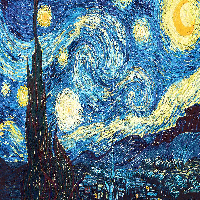

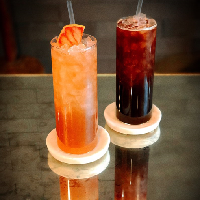

In [0]:
# GPU / CPU 환경 선택, 환경에 따라 이미지 크기 다르게 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
imsize = 512 if torch.cuda.is_available() else 128

# 이미지 크기 조절 후 Pytorch Tensor로 바꾸기 위한 loader 함수 생성
loader = transforms.Compose([transforms.Resize((imsize, imsize)), transforms.ToTensor()])

# 이미지를 불러와 Pytorch 에서 다루기 위한 Tensor로 바꾸기 위한 함수
def image_loader(image_name):
  image = Image.open(image_name).convert('RGB')

  # 이미지 출력
  image_2 = image.resize((200, 200))
  cv2_imshow(np.array(image_2)[:, :, ::-1])

  # CNN 모델 입력을 위해 Batch 차원 필요, 한 차원 더해준다
  image = loader(image).unsqueeze(0)
  
  return image.to(device, torch.float)

style_img = image_loader('/gdrive/My Drive/Colab Notebooks/gogh_style.png')
content_img = image_loader('/gdrive/My Drive/Colab Notebooks/coffee_content.png')

# Style 과 Content 이미지의 크기가 같아야 한다.
assert style_img.size() == content_img.size(), "we need to import style and content images of the same size"

In [0]:
# Content Loss 계산을 위한 클래스
class ContentLoss(nn.Module):

  def __init__(self, target,):
    super(ContentLoss, self).__init__()

    # Loss 계산은 하지만 직접 Gradient를 감소시키는 단계가 아니므로 Gradient 계산에서 떼어놓는다.
    self.target = target.detach()

  # Content와 Generated의 MSE 계산
  def forward(self, input):
    self.loss = F.mse_loss(input, self.target)
    return input

In [0]:
# Style Loss 계산을 위한 그람 행렬 함수 정의
def gram_matrix(input):
  # a = batch size(=1) / b = Feature map 수 / (c,d) = Feature map 차원
  a, b, c, d = input.size()  

  # [a,b,c,d] -> [a x b, c x d]의 행렬로 만들어 행렬곱 연산이 가능하도록 바꾼다.
  features = input.view(a * b, c * d)  

  # 자신의 전치 행렬과 행렬곱
  G = torch.mm(features, features.t())

  # 그람 행렬 정규화를 위해 각 차원의 값으로 다 나누어준다.
  return G.div(a * b * c * d)

# Style Loss 계산을 위한 클래스
class StyleLoss(nn.Module):
  def __init__(self, target_feature):
    super(StyleLoss, self).__init__()

    # 위와 마찬가지로 직접 Gradient를 감소시키는 단계가 아니므로 Gradient 계산에서 떼어놓는다.
    self.target = gram_matrix(target_feature).detach()

  def forward(self, input):
    # 그람 행렬 연산 후 MSE 적용
    G = gram_matrix(input)
    self.loss = F.mse_loss(G, self.target)
    return input

In [0]:
# VGG16 모델을 불러온다.
cnn = models.vgg16(pretrained=True).features.to(device).eval()
print(cnn)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [0]:
# 입력 이미지를 정규화하는 모듈을 만들어 새로 구성할 CNN 모델의 첫 층으로 사용한다.
class Normalization(nn.Module):
  def __init__(self, mean, std):
    super(Normalization, self).__init__()
    
    # mean과 std를 [C x 1 x 1] 형태로 만들어주어 [B x C x H x W] 형태의 이미지 연산에 바로 적용할 수 있도록 한다.
    # B는 batch size, C는 채널, H, W 는 각각 높이, 너비이므로, mean, std가 한번에 H x W의 이미지에 연산될 수 있도록 한다.
    self.mean = torch.tensor(mean).view(-1, 1, 1)
    self.std = torch.tensor(std).view(-1, 1, 1)

  def forward(self, img):
    # 이미지 정규화
    return (img - self.mean) / self.std

In [0]:
# style/content loss를 계산하고 싶은 Convolution 층 지정
content_layers = ['conv_7']
style_layers = ['conv_2', 'conv_4', 'conv_7', 'conv_10']

def get_model_and_losses(cnn, norm_mean, norm_std, style_img, content_img, 
                         content_layers=content_layers, style_layers=style_layers):
  cnn = copy.deepcopy(cnn) # VGG 모델에 대한 깊은 복사

  # 정규화 모듈
  normalization = Normalization(norm_mean, norm_std).to(device)

  # Content / Style losses를 추가해나가기 위한 빈 리스트
  content_losses = []
  style_losses = []

  # VGG 모델의 각 층에 이름을 붙이고 각 층을 새로운 모델을 만들고 normalization 층 뒤에 붙인다.
  model = nn.Sequential(normalization)

  i = 0  # Convolution Layer를 발견할 때 마다 증가
  for layer in cnn.children():

    # 이 층이 Convolution Layer 일 경우
    if isinstance(layer, nn.Conv2d): 
      i += 1
      name = 'conv_{}'.format(i) # 층에 conv_x 의 이름을 붙인다.

    # 이 층이 ReLU 활성화 함수 인 경우
    elif isinstance(layer, nn.ReLU):
      name = 'relu_{}'.format(i) # 층에 relu_x 의 이름을 붙인다.

      # in-place (복사본을 만들지 않는)는 ContentLoss와 StyleLoss에 잘 동작하지 않으므로 False
      layer = nn.ReLU(inplace=False)

    # 이 층이 Pooling Layer 인 경우
    elif isinstance(layer, nn.MaxPool2d):
      name = 'pool_{}'.format(i) # 층에 pool_x 의 이름을 붙인다.

    # 이 층이 Batch Normalization Layer 인 경우
    elif isinstance(layer, nn.BatchNorm2d):
      name = 'bn_{}'.format(i) # 층에 bn_x 의 이름을 붙인다.

    else: # 위의 Layer 이외의 경우 런타임 에러
      raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

    model.add_module(name, layer) # 위에서 이름 붙인 층을 model에 더한다.

    # content_layers 리스트에 넣은 Convolution Layer를 통한 Content Loss 정의
    if name in content_layers:
      # add content loss:
      target = model(content_img).detach() # content_img가 업데이트되진 않으므로 detach
      content_loss = ContentLoss(target)

      # 새로 정의한 CNN 모델에 Content Loss 계산 층을 더해준다.
      model.add_module("content_loss_{}".format(i), content_loss)

      content_losses.append(content_loss) # 리스트에 Loss 값 담기

    # style_layers 리스트에 넣은 Convolution Layer를 통한 Style Loss 정의
    if name in style_layers:
      # add style loss:
      target_feature = model(style_img).detach() # style_img가 업데이트되진 않으므로 detach
      style_loss = StyleLoss(target_feature)

      # 새로 정의한 CNN 모델에 Style Loss 계산 층을 더해준다.
      model.add_module("style_loss_{}".format(i), style_loss)

      style_losses.append(style_loss) # 리스트에 Loss 값 담기

  # Loss 뒤의 층은 쓸모없으므로 버린다.
  for i in range(len(model) - 1, -1, -1):
    # 층이 ContentLoss나 StyleLoss 층일 경우 중지
    if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss): 
      break
  model = model[:(i + 1)] # 기존 VGG16 모델 뒷부분 잘라내기

  return model, style_losses, content_losses

In [0]:
# 입력 이미지를 Content Image로 초기화
input_img = content_img.clone()

# 입력 이미지를 랜덤 노이즈로 초기화
#input_img = torch.randn(content_img.data.size(), device=device)

In [0]:
def style_transfer(cnn, norm_mean, norm_std, content_img, style_img, 
                   input_img, num_steps=300, style_weight=1000000, content_weight=1):
  """Style transfer 실행"""
  print('Building the style transfer model..')

  # 위에서 정의한 함수로 각 Loss 와 새로 만든 CNN 모델을 가져온다.
  model, style_losses, content_losses = get_model_and_losses(cnn, norm_mean, norm_std, style_img, content_img)

  # 입력 이미지를 업데이트 하는 Adam Optimizer 정의
  optimizer = optim.Adam([input_img.requires_grad_()])

  print('Optimizing..')
  run = [0] # 이미지 업데이트 횟수 기록을 위한 리스트
  while run[0] <= num_steps:

    def closure():
      # 업데이트 된 이미지의 범위를 0 ~ 1 사이로 제한시킨다.
      input_img.data.clamp_(0, 1)

      # 업데이트 후 남아있는 Gradient 값을 비운다.
      optimizer.zero_grad()

      # 모델에 입력 이미지 입력
      model(input_img)

      # 총 Loss 합산을 위한 변수 초기화
      style_score = 0
      content_score = 0

      # 반복문을 통해 각 Loss 합산
      for sl in style_losses:
        style_score += sl.loss
      for cl in content_losses:
        content_score += cl.loss

      # Content / Style Loss 각각에 Weight 곱한 후 더해서 총 Loss를 정의한다.
      style_score *= style_weight
      content_score *= content_weight
      loss = style_score + content_score

      # Loss 를 통한 Gradient 계산
      loss.backward() 

      run[0] += 1
      if run[0] % 100 == 0: # 100번 업데이트마다 각 Loss값 출력 
         print("run {}:".format(run))
         print('Style Loss : {:4f} Content Loss: {:4f}'.format(style_score.item(), content_score.item()))
         print()

      return loss

    # Adam Optimizer를 이용, 위의 closure를 통해 업데이트
    optimizer.step(closure)

  # 마지막 업데이트 후 이미지 범위 0 ~ 1 고정
  input_img.data.clamp_(0, 1)

  return input_img

In [0]:
# VGG 모델 학습 시 입력 데이터의 평균으로 정규화
cnn_norm_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_norm_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

In [0]:
# 실제 Style Transfer 실행
output = style_transfer(cnn, cnn_norm_mean, cnn_norm_std, 
                        content_img, style_img, input_img, 
                        num_steps=1000, style_weight=1000000, content_weight=1)

Building the style transfer model..
Optimizing..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


run [100]:
Style Loss : 53.659019 Content Loss: 58.846203

run [200]:
Style Loss : 44.348709 Content Loss: 61.364868

run [300]:
Style Loss : 39.280636 Content Loss: 62.743553

run [400]:
Style Loss : 35.910183 Content Loss: 63.558140

run [500]:
Style Loss : 33.391029 Content Loss: 64.072968

run [600]:
Style Loss : 31.390337 Content Loss: 64.411682

run [700]:
Style Loss : 29.779095 Content Loss: 64.626961

run [800]:
Style Loss : 28.584341 Content Loss: 64.769043

run [900]:
Style Loss : 27.279667 Content Loss: 64.892120

run [1000]:
Style Loss : 26.570301 Content Loss: 65.031456



(3, 512, 512)
(512, 512, 3)


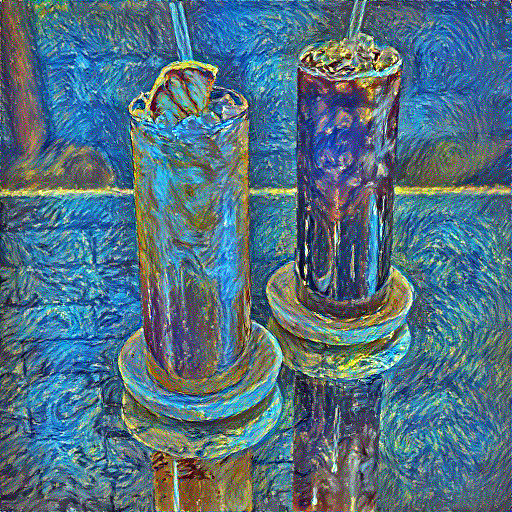

In [0]:
# 모델 출력을 이미지 출력으로 나타내기 위한 처리
output_img = output.detach().cpu().numpy()[0]*255
print(np.shape(output_img))

# 행렬 차원이 뒤집혀있으므로 바꾸어준다.
output_img = np.moveaxis(output_img, 0, -1)
print(np.shape(output_img))

# BGR -> RGB 출력
cv2_imshow(output_img[:,:,::-1])